In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorly as tl
from util import random_matrix_generator, square_tensor_gen, inner_product
from simulation import Simulation, DimRedux, Simulations
import pickle
import matplotlib

Using numpy backend.


In [2]:
k = 30    
d = 2500
n = 10
ks = np.arange(10, 60, 5)
X = np.random.normal(0,1,(d, n))

In [5]:
# Simulation for Random Projection (Length preservation)
k = 30    
d = 2500
n = 10
ks = np.arange(10, 60, 5)
X = np.random.normal(0,1,(d, n))
redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True) 
redux7 = DimRedux('g',k, d, krao = True, vr = True, vr_typ = 'norm_mean') 
redux8 = DimRedux('sp0',k, d, krao = True)
redux9 = DimRedux('sp0',k, d, krao = True, vr = True, vr_typ = 'norm_mean')
redux10 = DimRedux('sp1',k, d, krao = True)
redux11 = DimRedux('sp1',k, d, krao = True, vr = True, vr_typ = 'norm_mean')

reduxs1 = [redux1, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]
reduxs3 = [redux4, redux8, redux9] 
reduxs4 = [redux4, redux10, redux11] 


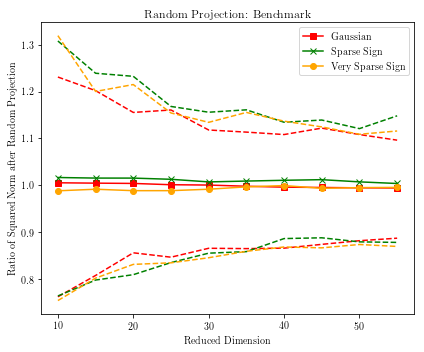

In [3]:
sims1 = Simulations(X, reduxs1)
sims1_result = sims1.run_varyk(ks)
sims1.plot_varyk(sims1_result, ks, ["Gaussian", \
    "Sparse Sign","Very Sparse Sign"], 'Random Projection: Benchmark', 'rp_benchmark')

# Random Projection for Gaussian, N = 2 

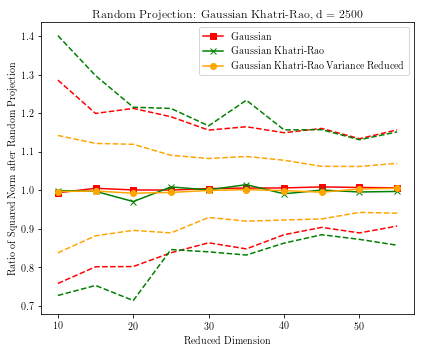

In [4]:
d = 2500

sims2 = Simulations(X, reduxs2)
sims2_result = sims2.run_varyk(ks) 
sims2.plot_varyk(sims2_result, ks, ["Gaussian","Gaussian Khatri-Rao", \
    "Gaussian Khatri-Rao Variance Reduced"], 'Random Projection: Gaussian Khatri-Rao, d = '+str(d), 'rp_g_krao_d'+str(d))

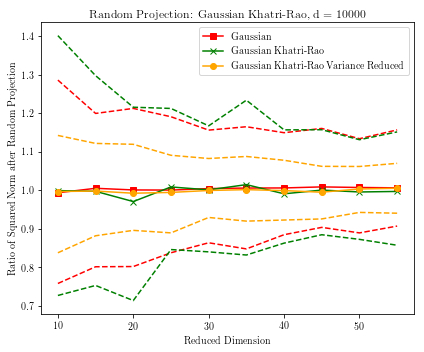

In [6]:
d = 10000

sims2 = Simulations(X, reduxs2)
sims2_result = sims2.run_varyk(ks) 
sims2.plot_varyk(sims2_result, ks, ["Gaussian","Gaussian Khatri-Rao", \
    "Gaussian Khatri-Rao Variance Reduced"], 'Random Projection: Gaussian Khatri-Rao, d = '+str(d), 'rp_g_krao_d'+str(d))

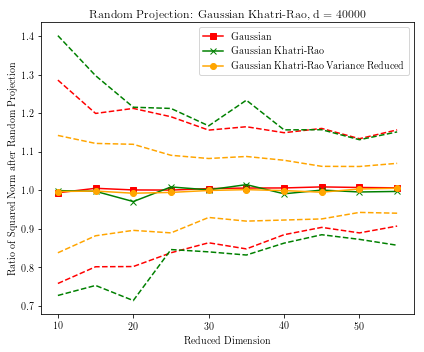

In [8]:
d = 40000

sims2 = Simulations(X, reduxs2)
sims2_result = sims2.run_varyk(ks) 
sims2.plot_varyk(sims2_result, ks, ["Gaussian","Gaussian Khatri-Rao", \
    "Gaussian Khatri-Rao Variance Reduced"], 'Random Projection: Gaussian Khatri-Rao, d = '+str(d), 'rp_g_krao_d'+str(d))

# Random Projection for Sparse, N = 2

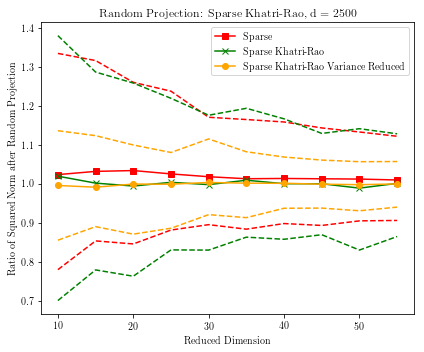

In [9]:
d = 2500

sims3 = Simulations(X, reduxs3)
sims3_result = sims3.run_varyk(ks) 
sims3.plot_varyk(sims3_result, ks, ["Sparse","Sparse Khatri-Rao", \
    "Sparse Khatri-Rao Variance Reduced"], 'Random Projection: Sparse Khatri-Rao, d = '+str(d), 'rp_sp0_krao_d'+str(d))

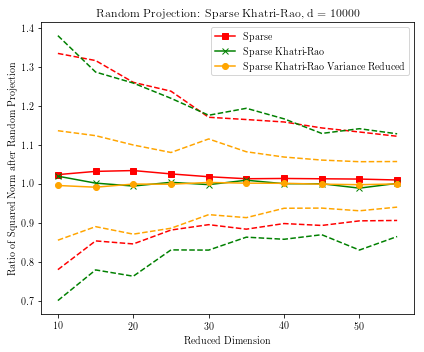

In [10]:
d = 10000

sims3 = Simulations(X, reduxs3)
sims3_result = sims3.run_varyk(ks) 
sims3.plot_varyk(sims3_result, ks, ["Sparse","Sparse Khatri-Rao", \
    "Sparse Khatri-Rao Variance Reduced"], 'Random Projection: Sparse Khatri-Rao, d = '+str(d), 'rp_sp0_krao_d'+str(d))

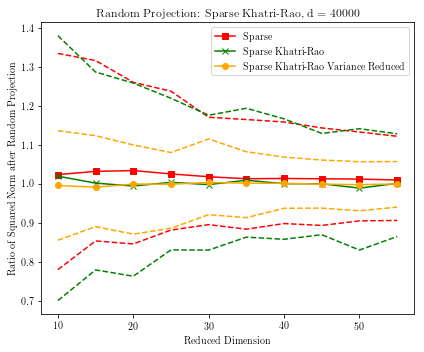

In [11]:
d = 40000

sims3 = Simulations(X, reduxs3)
sims3_result = sims3.run_varyk(ks) 
sims3.plot_varyk(sims3_result, ks, ["Sparse","Sparse Khatri-Rao", \
    "Sparse Khatri-Rao Variance Reduced"], 'Random Projection: Sparse Khatri-Rao, d = '+str(d), 'rp_sp0_krao_d'+str(d))

# Random Projection for Very Sparse N = 2

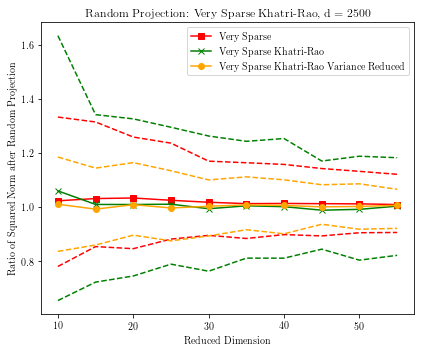

In [12]:
d = 2500

sims4 = Simulations(X, reduxs4)
sims4_result = sims4.run_varyk(ks) 
sims4.plot_varyk(sims4_result, ks, ["Very Sparse","Very Sparse Khatri-Rao", \
    "Very Sparse Khatri-Rao Variance Reduced"], 'Random Projection: Very Sparse Khatri-Rao, d = '+str(d), 'rp_sp1_krao_d'+str(d))

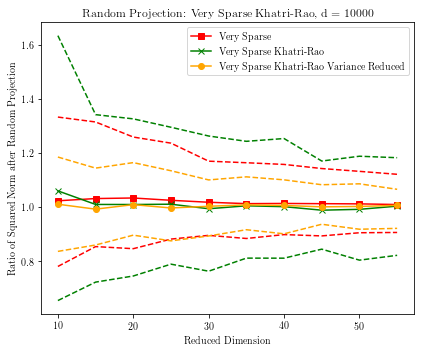

In [13]:
d = 10000

sims4 = Simulations(X, reduxs4)
sims4_result = sims4.run_varyk(ks) 
sims4.plot_varyk(sims4_result, ks, ["Very Sparse","Very Sparse Khatri-Rao", \
    "Very Sparse Khatri-Rao Variance Reduced"], 'Random Projection: Very Sparse Khatri-Rao, d = '+str(d), 'rp_sp1_krao_d'+str(d))

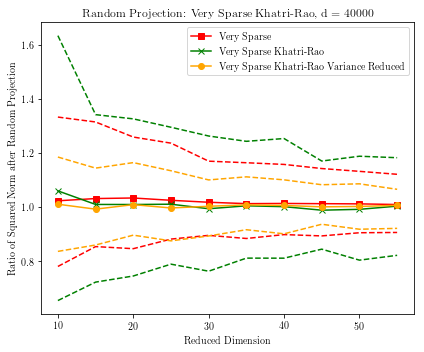

In [14]:
d = 40000

sims4 = Simulations(X, reduxs4)
sims4_result = sims4.run_varyk(ks) 
sims4.plot_varyk(sims4_result, ks, ["Very Sparse","Very Sparse Khatri-Rao", \
    "Very Sparse Khatri-Rao Variance Reduced"], 'Random Projection: Very Sparse Khatri-Rao, d = '+str(d), 'rp_sp1_krao_d'+str(d))

# Random Projectionk for Gaussian, N = 3

In [10]:
# Simulation for Random Projection (Length preservation)
k = 30    
d = 125000
n = 10
ks = np.arange(10, 35, 5)
X = np.random.normal(0,1,(d, n))
krao_ms = np.repeat(50,3)

redux1 = DimRedux('g',k, d) 
redux6 = DimRedux('g',k, d, krao = True, krao_ms = krao_ms) 
redux7 = DimRedux('g',k, d, krao = True, krao_ms = krao_ms, vr = True, vr_typ = 'norm_mean') 

reduxs = [redux1, redux6,redux7]

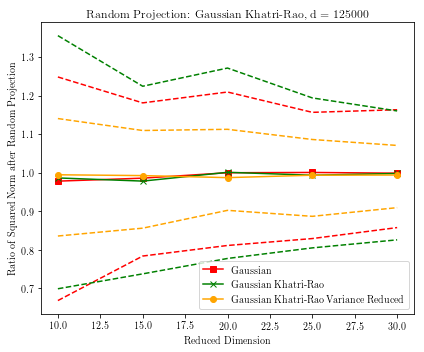

In [11]:
sims5 = Simulations(X, reduxs)
sims5_result = sims5.run_varyk(ks) 
sims5.plot_varyk(sims5_result, ks, ["Gaussian","Gaussian Khatri-Rao", \
    "Gaussian Khatri-Rao Variance Reduced"], 'Random Projection: Gaussian Khatri-Rao, d = '+str(d), 'rp_g_krao_d'+str(d))

# Simulation for Sketching 

In [15]:
# Simulation for Sketching (Column Space preservation)
k = 30
d = 400
X = square_tensor_gen(d, r = 5, dim = 2, typ = 'lk', noise_level=0.1)[0]

ks = np.arange(5,30,5) 
redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True) 
redux7 = DimRedux('g',k, d, krao = True, vr = True, vr_typ = 'geom_median_l2') 
reduxs1 = [redux1, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]


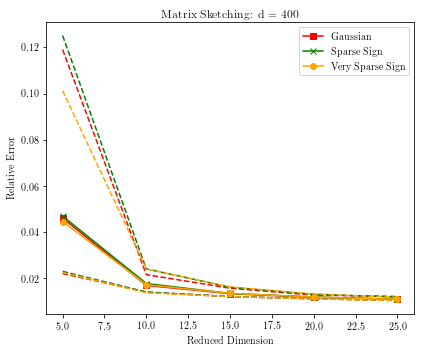

In [16]:
sims_colspace1 = Simulations(X, reduxs1)
sims_colspace1.plot_colspace_varyk(sims_colspace1.run_colspace_varyk(ks), ks, ["Gaussian", \
    "Sparse Sign","Very Sparse Sign"], 'Matrix Sketching: d = '+str(d), 'col_benchmark_d'+str(d)) 

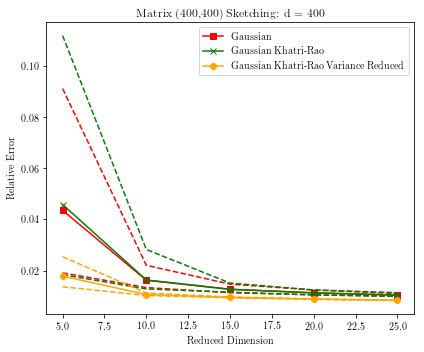

In [17]:
dim = 2 
X = square_tensor_gen(d, r = 5, dim = dim, typ = 'lk', noise_level=0.1)[0]
sims_colspace2 = Simulations(X, reduxs2)
sims_colspace2_result = sims_colspace2.run_colspace_varyk(ks)
pickle.dump(sims_colspace2_result, open("data/col_dim"+str(dim)+"_krao_d"+str(d)+".pickle", "wb" ))
sims_colspace2_result = pickle.load( open("data/col_dim"+str(dim)+"_krao_d"+str(d)+".pickle", "rb" ) )
sims_colspace2.plot_colspace_varyk(sims_colspace2_result, ks, ["Gaussian","Gaussian Khatri-Rao", \
    "Gaussian Khatri-Rao Variance Reduced"], 'Matrix (400,400) Sketching: d = '+str(d), 'col_dim'+str(dim)+'_krao_d'+str(d)) 

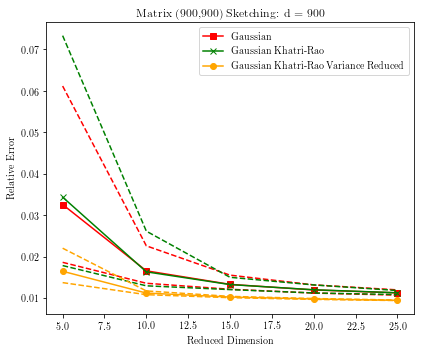

In [18]:
k = 30
d = 900
dim = 2 
X = square_tensor_gen(d, r = 5, dim = dim, typ = 'lk', noise_level=0.1)[0]

ks = np.arange(5,30,5) 
redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True) 
redux7 = DimRedux('g',k, d, krao = True, vr = True, vr_typ = 'geom_median_l2') 
reduxs1 = [redux1, redux2, redux3, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]


sims_colspace3 = Simulations(X, reduxs2)
sims_colspace3_result = sims_colspace3.run_colspace_varyk(ks)
pickle.dump(sims_colspace3_result, open("data/col_dim"+str(dim)+"_krao_d"+str(d)+".pickle", "wb" ))
sims_colspace3_result = pickle.load( open("data/col_dim"+str(dim)+"_krao_d"+str(d)+".pickle", "rb" ) )
sims_colspace3.plot_colspace_varyk(sims_colspace3_result, ks, ["Gaussian","Gaussian Khatri-Rao", \
    "Gaussian Khatri-Rao Variance Reduced"], 'Matrix (900,900) Sketching: d = '+str(d), 'col_dim'+str(dim)+'_krao_d'+str(d)) 

In [17]:
# Need to add tensor plot 

In [20]:
def dim_str(n,dim): 
    result = "("+str(n) 
    for i in range(dim-1):  
        result = result+", "+str(n)
    return result+")"

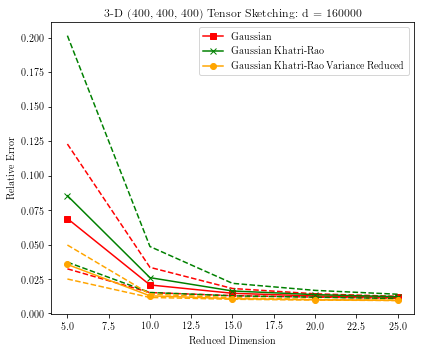

In [21]:
k = 30
n = 400
dim = 3
X0 = square_tensor_gen(n, r = 5, dim = dim, typ = 'lk', noise_level=0.1)[0]
X = tl.unfold(X0,mode = 0).T
d = X.shape[0]
krao_ms = np.repeat(int(np.sqrt(n)),2*(dim - 1))

ks = np.arange(5,30,5) 
redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True, krao_ms = krao_ms) 
redux7 = DimRedux('g',k, d, krao = True, krao_ms = krao_ms, vr = True, vr_typ = 'geom_median_l2') 
reduxs1 = [redux1, redux2, redux3, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]

sims_colspace4 = Simulations(X, reduxs2)
#sims_colspace4_result = sims_colspace4.run_colspace_varyk(ks)
#pickle.dump(sims_colspace4_result, open("data/col_dim"+str(dim)+"_krao_d"+str(d)+".pickle", "wb" ))
sims_colspace4_result = pickle.load( open("data/col_dim"+str(dim)+"_krao_d"+str(d)+".pickle", "rb" ) )
sims_colspace4.plot_colspace_varyk(sims_colspace4_result, ks, ["Gaussian","Gaussian Khatri-Rao", \
    "Gaussian Khatri-Rao Variance Reduced"], str(dim)+"-D "+dim_str(n,dim)+" Tensor Sketching: d = "+str(d),"col_dim"+ str(dim)+"_krao_d"+str(d)) 


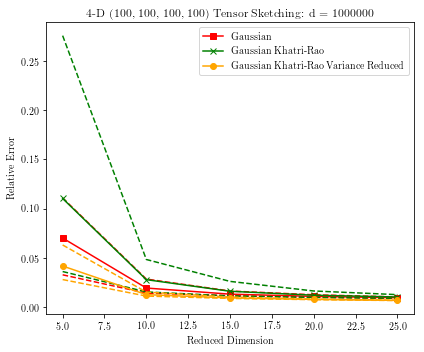

In [23]:
k = 30
n = 100
dim = 4
X0 = square_tensor_gen(n, r = 5, dim = dim, typ = 'lk', noise_level=0.1)[0]
X = tl.unfold(X0,mode = 0).T
d = X.shape[0]
krao_ms = np.repeat(int(np.sqrt(n)),2*(dim - 1))

ks = np.arange(5,30,5) 
redux1 = DimRedux('g',k, d) 
redux2 = DimRedux('u',k, d)
redux3 = DimRedux('sgn',k, d)
redux4 = DimRedux('sp0',k, d) 
redux5 = DimRedux('sp1',k, d) 
redux6 = DimRedux('g',k, d, krao = True, krao_ms = krao_ms) 
redux7 = DimRedux('g',k, d, krao = True, krao_ms = krao_ms, vr = True, vr_typ = 'geom_median_l2') 
reduxs1 = [redux1, redux2, redux3, redux4, redux5] 
reduxs2 = [redux1, redux6, redux7]


sims_colspace5 = Simulations(X, reduxs2)
#sims_colspace5_result = sims_colspace5.run_colspace_varyk(ks)
#pickle.dump(sims_colspace5_result, open("data/col_dim"+str(dim)+"_krao_d"+str(d)+".pickle", "wb" ))
sims_colspace5_result = pickle.load( open("data/col_dim"+str(dim)+"_krao_d"+str(d)+".pickle", "rb" ) )
sims_colspace5.plot_colspace_varyk(sims_colspace5_result, ks, ["Gaussian","Gaussian Khatri-Rao", \
    "Gaussian Khatri-Rao Variance Reduced"], str(dim)+"-D "+dim_str(n,dim)+" Tensor Sketching: d = "+str(d), "col_dim"+ str(dim)+"_krao_d"+str(d)) 


# MNIST Example 

In [7]:
import mnist
import scipy.misc

In [8]:
k = 10
train_images = mnist.train_images()
train_images.shape

(60000, 28, 28)

In [10]:
relerrs = pickle.load( open("data/mnist_errs.pickle", "rb" ) )

In [11]:
relerrs

[1948.2823556850904,
 1881.2942894966984,
 3060.1626657256134,
 2499.954435775406,
 1369.562935275874,
 3137.7587799355765,
 3581.58934419122,
 2100.213299383069,
 3370.106533553359]

In [88]:
def quantize(x, precision = 1e2): 
    upper = np.ceil(x/precision)*precision
    lower = np.floor(x/precision)*precision
    return np.random.choice([lower, upper],1, p = [(x-lower)/(upper - lower), (upper-x)/(upper - lower)])

In [89]:
def quantize_mat(X, precision = 1e-2):
    shp = X.shape
    X_vec = X.reshape(X.size) 
    X_vec_new = np.vectorize(lambda x: quantize(x, precision))(X_vec)
    return(X_vec_new.reshape(shp))


array([[3.14, 3.14, 3.14, 3.15, 3.15, 3.14, 3.14, 3.15, 3.15, 3.14],
       [3.15, 3.14, 3.15, 3.15, 3.15, 3.14, 3.14, 3.14, 3.14, 3.14],
       [3.14, 3.14, 3.15, 3.15, 3.14, 3.15, 3.14, 3.15, 3.14, 3.15],
       [3.14, 3.15, 3.15, 3.14, 3.14, 3.14, 3.15, 3.14, 3.15, 3.15],
       [3.14, 3.15, 3.14, 3.14, 3.14, 3.15, 3.14, 3.15, 3.15, 3.14],
       [3.14, 3.14, 3.15, 3.14, 3.14, 3.14, 3.14, 3.14, 3.15, 3.14],
       [3.15, 3.14, 3.14, 3.15, 3.15, 3.15, 3.15, 3.14, 3.14, 3.15],
       [3.15, 3.14, 3.15, 3.14, 3.14, 3.15, 3.14, 3.15, 3.14, 3.15],
       [3.14, 3.15, 3.14, 3.14, 3.14, 3.15, 3.14, 3.15, 3.14, 3.15],
       [3.14, 3.14, 3.14, 3.14, 3.14, 3.14, 3.14, 3.14, 3.14, 3.15]])